Begun 12/12/24

Doing all the chi2 tests on all 264 maps after correcting the number of modes for the modes lost by ivar weighting. Using cuts identified in data_quality_larger_set_corrected_mode_count_20241212.ipynb.

Results are in angle_calc_1733966436

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import pandas as pd
import nawrapper as nw
import yaml
import time
import healpy as hp
from scipy import optimize as op
import os
from scipy.stats.distributions import chi2
from itertools import combinations

In [2]:
# Loading spectra from run
spectra_dict = np.load('/home/zbh5/act_analysis/act_axion_analysis/results/angle_calc_1733966436/angle_calc_1733966436_spectra.npy',allow_pickle=True).item()

In [3]:
maps = np.array(list(spectra_dict.keys()))
n_maps = len(maps)
print(n_maps)
print(spectra_dict[maps[0]].keys())

264
dict_keys(['ell', 'E1xB2', 'E2xB1', 'E1xE1', 'B2xB2', 'E2xE2', 'B1xB1', 'E1xE2', 'B1xB2', 'E1xB1', 'E2xB2', 'binned_nu', 'estimator', 'covariance', 'CAMB_EE', 'CAMB_BB', 'w2_depth1', 'w2_cross', 'w2_ref', 'meas_angle', 'meas_errbar', 'ivar_sum', 'residual_mean', 'residual_sum', 'map_cut'])


In [4]:
# Implementing automatic data cuts
cut_flags = np.zeros(n_maps)
ivar_sums = np.zeros(n_maps)
all_errbars = np.zeros(n_maps)
residual_sums = np.zeros(n_maps)
angles_rad = np.zeros(n_maps)
errbars_rad = np.zeros(n_maps)
for i in range(n_maps):
    cut_flags[i] = spectra_dict[maps[i]]['map_cut']
    all_errbars[i] = spectra_dict[maps[i]]['meas_errbar']
    ivar_sums[i] = spectra_dict[maps[i]]['ivar_sum']
    residual_sums[i] = spectra_dict[maps[i]]['residual_sum']
    angles_rad[i] = np.deg2rad(spectra_dict[maps[i]]['meas_angle'])
    errbars_rad[i] = np.deg2rad(spectra_dict[maps[i]]['meas_errbar'])

print("Total number of maps: ", n_maps)
# Identifying maps that weren't cut by the galaxy mask
cut_good = np.where(cut_flags != 1)[0]
print("Maps passing galaxy mask cut: ", len(cut_good))
# Using the super small errorbars to identify the failed fits - there were none in this run
errbar_good = np.where(all_errbars>0.1)[0]
print("Maps passing bad fit cut: ", len(errbar_good))
# Using residual cutoff of 2000 - cuts come from analysis in data_quality_larger_set_corrected_mode_count_20241212.ipynb
residual_good = np.where(residual_sums<2000)[0]
print("Maps passing residual cut: ", len(residual_good))
# Using ivar cutoff of 4.0
ivar_good = np.where(ivar_sums>4.0)[0]
print("Maps passing ivar cut: ", len(ivar_good))
# Taking the intersection of these four sets to get those maps that pass all cuts
set_pass_all_cuts = np.intersect1d(np.intersect1d(np.intersect1d(cut_good,errbar_good),residual_good),ivar_good)
print("Maps passing all four cuts: ", len(set_pass_all_cuts))
print(set_pass_all_cuts)

Total number of maps:  264
Maps passing galaxy mask cut:  256
Maps passing bad fit cut:  256
Maps passing residual cut:  115
Maps passing ivar cut:  176
Maps passing all four cuts:  95
[ 20  21  23  24  25  26  27  29  30  37  38  47  48  51  56  59  60  63
  64  68  69  70  72  73  75  76  80  81  82  84  85  87  88  89  90  91
  93  94  96  97  99 100 105 113 115 116 117 119 120 122 123 128 131 132
 136 137 150 151 156 157 159 160 162 163 173 174 175 176 177 179 180 182
 183 185 186 187 193 195 196 197 199 205 206 210 218 219 221 227 232 233
 243 244 245 247 251]


In [5]:
# Extracting map info and results into separate arrays for ease of access
map_arrays = []
map_timestamps = []
estimators = []
covariances = []

for i in range(n_maps):
    map_arrays.append(maps[i].split('_')[2])
    map_timestamps.append(maps[i].split('_')[1])
    estimators.append(spectra_dict[maps[i]]['estimator'])
    covariances.append(spectra_dict[maps[i]]['covariance'])
map_arrays = np.array(map_arrays)
map_timestamps = np.array(map_timestamps)
estimators = np.array(estimators)
covariances = np.array(covariances)

In [6]:
good_maps = np.array(maps[set_pass_all_cuts])
print("Total number of maps passing cuts: ", len(good_maps))
print("Total number of maps: ", n_maps)
print("Number of PA4 maps passing cuts: ",len(np.where(map_arrays[set_pass_all_cuts]=='pa4')[0]))
print("Total number of PA4 maps: ", len(np.where(map_arrays=='pa4')[0]))
print("Number of PA5 maps passing cuts: ",len(np.where(map_arrays[set_pass_all_cuts]=='pa5')[0]))
print("Total number of PA5 maps: ", len(np.where(map_arrays=='pa5')[0]))
print("Number of PA6 maps passing cuts: ",len(np.where(map_arrays[set_pass_all_cuts]=='pa6')[0]))
print("Total number of PA6 maps: ", len(np.where(map_arrays=='pa6')[0]))
good_timestamps = np.array([m.split('_')[1] for m in good_maps])
unique_good_timestamps = np.unique(good_timestamps)
print("Number of unique timestamps that pass cuts: ", len(unique_good_timestamps))

Total number of maps passing cuts:  95
Total number of maps:  264
Number of PA4 maps passing cuts:  10
Total number of PA4 maps:  88
Number of PA5 maps passing cuts:  48
Total number of PA5 maps:  92
Number of PA6 maps passing cuts:  37
Total number of PA6 maps:  84
Number of unique timestamps that pass cuts:  49


In [7]:
# Generating a list of all pairs of indices that need to be processed
# Also makes a list of strings showing which arrays each pair goes with for easy counting
all_pairs = []
all_pairs_array_tags = []
for timestamp in unique_good_timestamps:
    indices = set_pass_all_cuts[np.where(good_timestamps==timestamp)[0]] # Getting indices from full list
    if len(indices)>1:
        pairs = [comb for comb in combinations(indices,r=2)]
        for pair in pairs:
            all_pairs.append(pair)
            all_pairs_array_tags.append(map_arrays[pair[0]]+map_arrays[pair[1]])
all_pairs = np.array(all_pairs)
all_pairs_array_tags = np.array(all_pairs_array_tags)
# Getting indices within all_pairs for each set of arrays
pa4pa5_indices = np.where(all_pairs_array_tags=='pa4pa5')[0]
pa4pa6_indices = np.where(all_pairs_array_tags=='pa4pa6')[0]
pa5pa6_indices = np.where(all_pairs_array_tags=='pa5pa6')[0]
print("Total number of array difference pairs: ", len(all_pairs))
print("Total number of array tags: ", len(all_pairs_array_tags))
print("Number of pa4-pa5 pairs: ", pa4pa5_indices.size)
print("Number of pa4-pa6 pairs: ", pa4pa6_indices.size)
print("Number of pa5-pa6 pairs: ", pa5pa6_indices.size)

Total number of array difference pairs:  55
Total number of array tags:  55
Number of pa4-pa5 pairs:  10
Number of pa4-pa6 pairs:  9
Number of pa5-pa6 pairs:  36


In [8]:
#maps[all_pairs]

In [9]:
# Forming chi-squared for array difference null test and calculating PTE for each pair
chi2_all_pairs = []
pte_all_pairs = []
est_diff_all_pairs = []
cov_sum_all_pairs = []

for pair in all_pairs:
    est_diff = estimators[pair[0]] - estimators[pair[1]]
    cov_sum = covariances[pair[0]] + covariances[pair[1]]
    chi2_pair = np.sum(est_diff**2/(cov_sum)) # Assuming expected value of zero for difference of estimators
    dof_pair = est_diff.size - 1 # Should be same each time
    pte_pair = chi2.sf(chi2_pair,dof_pair)
    est_diff_all_pairs.append(est_diff)
    cov_sum_all_pairs.append(cov_sum)
    chi2_all_pairs.append(chi2_pair)
    pte_all_pairs.append(pte_pair)
est_diff_all_pairs = np.array(est_diff_all_pairs)
cov_sum_all_pairs = np.array(cov_sum_all_pairs)
chi2_all_pairs = np.array(chi2_all_pairs)
pte_all_pairs = np.array(pte_all_pairs)

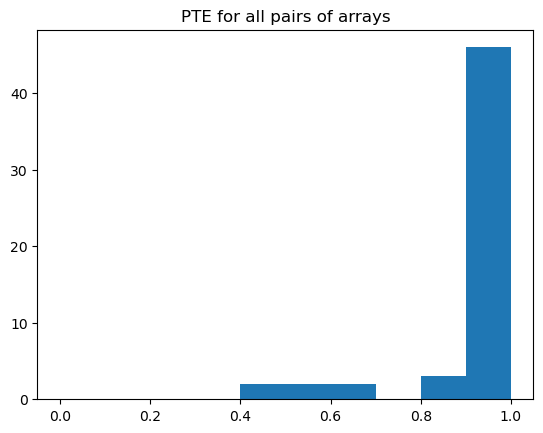

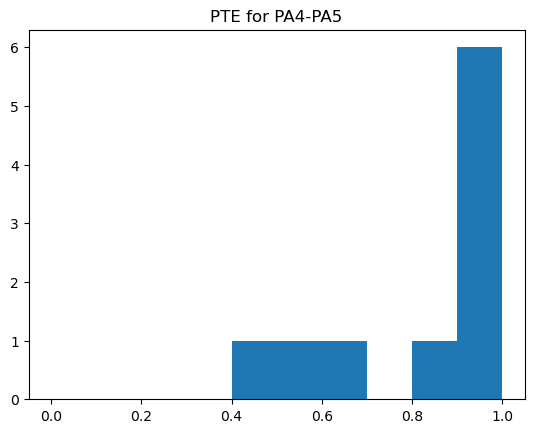

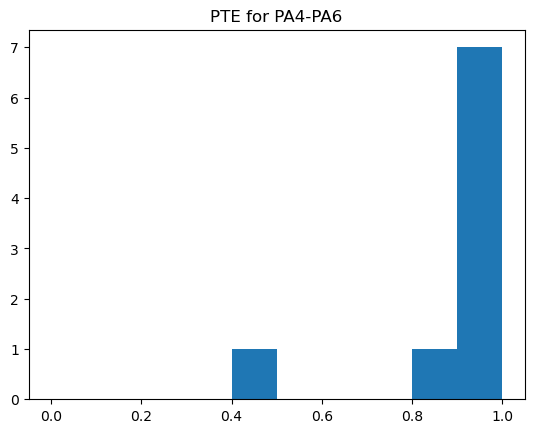

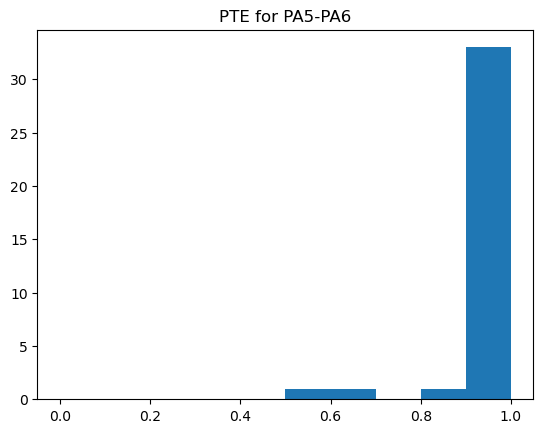

In [10]:
# Making PTE distribution plots 
# All pairs
plt.hist(pte_all_pairs,bins=10,range=(0.0,1.0))
plt.title("PTE for all pairs of arrays")
plt.show()
plt.close()
# PA4-PA5
plt.hist(pte_all_pairs[pa4pa5_indices],bins=10,range=(0.0,1.0))
plt.title("PTE for PA4-PA5")
plt.show()
plt.close()
# PA4-PA6
plt.hist(pte_all_pairs[pa4pa6_indices],bins=10,range=(0.0,1.0))
plt.title("PTE for PA4-PA6")
plt.show()
plt.close()
# PA5-PA6
plt.hist(pte_all_pairs[pa5pa6_indices],bins=10,range=(0.0,1.0))
plt.title("PTE for PA5-PA6")
plt.show()
plt.close()

In [11]:
# Calculating chi2 for each map compared to theory for the best fit angle
# for all maps that pass cuts
chi2_good_maps = []
pte_good_maps = []

test_CAMB_EE = spectra_dict[maps[0]]['CAMB_EE']

for idx in set_pass_all_cuts:
    null = estimators[idx] - test_CAMB_EE*np.sin(2*angles_rad[idx])
    sum_cov = covariances[idx] + (test_CAMB_EE*np.sin(2*errbars_rad[idx]))**2 # correct in small angle approx, I think
    chi2_good_map = np.sum(null**2/(1.0*sum_cov))
    dof_good_map = null.size - 1 # Should be the same each time
    pte_good_map = chi2.sf(chi2_good_map,dof_good_map)
    chi2_good_maps.append(chi2_good_map)
    pte_good_maps.append(pte_good_map)
chi2_good_maps = np.array(chi2_good_maps)
pte_good_maps = np.array(pte_good_maps)

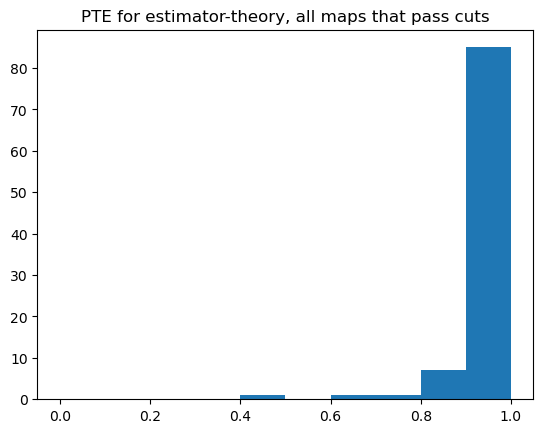

In [12]:
plt.hist(pte_good_maps,bins=10,range=(0.0,1.0))
plt.title("PTE for estimator-theory, all maps that pass cuts")
plt.show()
plt.close()